# Merging Data and Creating Plotly Visualizations

## Import Libraries and Data

In [86]:
# Import Libraries
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go

In [87]:
# Import Data
df_covid = pd.read_csv("https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv")
df_population = pd.read_csv("original_data_files/ACSST1Y2018.S0101_data_with_overlays_2020-04-02T080504.csv")
df_states = pd.read_excel("original_data_files/state-geocodes-v2018.xlsx")
df_counties = pd.read_excel("original_data_files/all-geocodes-v2018.xlsx")
df_hospitals = pd.read_csv("original_data_files/Hospitals.csv")

## Clean and Merge Data

### 1. Clean and edit down American Community Survey Population Data to get categories of total population, 18 and under, 60 and older, etc. 

In [88]:
#df_population.head()
#df_population.columns.tolist()

In [89]:
# make the first row (Row 0) the column header names
df_population.columns = df_population.iloc[0]

# remove the first row to make the dataframe all of the data after the first row
df_population = df_population[1:]

In [90]:
# make a list of all columns that start with "Margin of Error"
margin_error = df_population.columns.str.startswith("Margin of Error!!")
# keeep only NOT true values for margin of error
df_pop_values = df_population.loc[:, ~margin_error]

# remove columns that have a (X) value 
df_us_pop = df_pop_values.drop(columns=df_pop_values.columns[(df_pop_values == '(X)').any()])

# strip "Estimate!!" from columns because it's on the outside of the name
df_us_pop.columns = df_us_pop.columns.str.strip("Estimate!!")

# remove !!Total population from column headers by replacing with nothing
df_us_pop.columns = df_us_pop.columns.str.replace("!!Total population", "")

In [91]:
# make list of columns we want to keep for analysis
uspop_col = ['d',
             'Geographic Area N',
             'Total',
             'Male',
             'Female',
             'Total!!SELECTED AGE CATEGORIES!!Under 18 year',
             'Male!!SELECTED AGE CATEGORIES!!Under 18 year',
             'Female!!SELECTED AGE CATEGORIES!!Under 18 year',
             'Total!!SELECTED AGE CATEGORIES!!60 years and over',
             'Male!!SELECTED AGE CATEGORIES!!60 years and over',
             'Female!!SELECTED AGE CATEGORIES!!60 years and over',
             'Total!!SUMMARY INDICATORS!!Median age (years)',
             'Total!!SUMMARY INDICATORS!!Sex ratio (males per 100 females)',
             'Total!!SUMMARY INDICATORS!!Age dependency ratio',
             'Total!!SUMMARY INDICATORS!!Old-age dependency ratio',
             'Total!!SUMMARY INDICATORS!!Child dependency ratio',
            ]

# make new dataframe with only new column subset
df_us_pop_filter = df_us_pop.filter(items = uspop_col)

# remove "!!SELECTED AGE CATEGORIES!!" from column headers
df_us_pop_filter.columns = df_us_pop_filter.columns.str.replace("!!SELECTED AGE CATEGORIES!!", " ")

# remove "TOTAL!!!SUMMARY INDICATORS!!" from column headers
df_us_pop_filter.columns = df_us_pop_filter.columns.str.replace("Total!!SUMMARY INDICATORS!!", "")

In [92]:
# df_population.columns.tolist()
df_us_pop_filter.head()

,d,Geographic Area N,Total,Male,Female,Total Under 18 year,Male Under 18 year,Female Under 18 year,Total 60 years and over,Male 60 years and over,Female 60 years and over,Median age (years),Sex ratio (males per 100 females),Age dependency ratio,Old-age dependency ratio,Child dependency ratio
1,0500000US01117,"Shelby County, Alabama",215707,105022,110685,48670,25382,23288,47098,21899,25199,40.4,94.9,61.3,24.9,36.4
2,0500000US01121,"Talladega County, Alabama",79828,38489,41339,16810,8292,8518,20479,8991,11488,41.5,93.1,64.3,29.7,34.6
3,0500000US01125,"Tuscaloosa County, Alabama",208911,99576,109335,43992,21652,22340,39432,18110,21322,33.0,91.1,52.0,20.0,32.0
4,0500000US04021,"Pinal County, Arizona",447138,233292,213846,101143,52140,49003,118634,56331,62303,39.8,109.1,75.2,35.6,39.6
5,0500000US06045,"Mendocino County, California",87606,43017,44589,18535,9033,9502,25968,12178,13790,42.9,96.5,75.2,38.1,37.1


### 2. Edit Geographic State and County Data to include a full county FIPS code

In [93]:
#df_states.head()

In [94]:
#df_counties.head()

In [95]:
# re-import state data
df_states = pd.read_excel("original_data_files/state-geocodes-v2018.xlsx", skiprows = 5)

# re-import countydata
df_county = pd.read_excel("original_data_files/all-geocodes-v2018.xlsx", skiprows = 4)

In [96]:
# remove if county code is 0 (entire united states)
df_county = df_county[df_county["County Code (FIPS)"] != 0]

# convert state and county fips columns to strings
df_county[["State Code (FIPS)", "County Code (FIPS)"]] = df_county[["State Code (FIPS)", "County Code (FIPS)"]].astype(str)

# add leading zeros for a two digit value in state fips
df_county["State Code (FIPS)"] = df_county["State Code (FIPS)"].str.zfill(2)

# add leading zeros for three digit value in county fips
df_county["County Code (FIPS)"] = df_county["County Code (FIPS)"].str.zfill(3)

# make full county fips number
df_county["full_county_fips"] = df_county["State Code (FIPS)"] + df_county["County Code (FIPS)"]

# make full county fips number
df_county["full_county_fips"] = df_county["State Code (FIPS)"] + df_county["County Code (FIPS)"]

In [97]:
df_county.head()

,Summary Level,State Code (FIPS),County Code (FIPS),County Subdivision Code (FIPS),Place Code (FIPS),Consolidtated City Code (FIPS),Area Name (including legal/statistical area description),full_county_fips
2,50,01,001,0,0,0,Autauga County,01001
3,50,01,003,0,0,0,Baldwin County,01003
4,50,01,005,0,0,0,Barbour County,01005
5,50,01,007,0,0,0,Bibb County,01007
6,50,01,009,0,0,0,Blount County,01009


### 3. Merge County and State data to create County, State unique identifier

In [98]:
#df_states.head()

In [99]:
#df_county.head()

In [100]:
# convert state fips code to string
df_states["State (FIPS)"] = df_states["State (FIPS)"].astype(str)

# add preceding zeros to make 2-digit FIPS codes
df_states["State (FIPS)"] = df_states["State (FIPS)"].str.zfill(2)

In [101]:
# merge state name onto county fips dataframe
df_county = pd.merge(df_county, 
                     df_states[["State (FIPS)", "Name"]], 
                     how = "left", 
                     left_on = "State Code (FIPS)", 
                     right_on = "State (FIPS)")

# create column of county state and name
df_county["county_state_name"] = df_county["Area Name (including legal/statistical area description)"] + ", " + df_county["Name"]

In [102]:
df_county.head()

,Summary Level,State Code (FIPS),County Code (FIPS),County Subdivision Code (FIPS),Place Code (FIPS),Consolidtated City Code (FIPS),Area Name (including legal/statistical area description),full_county_fips,State (FIPS),Name,county_state_name
0,50,01,001,0,0,0,Autauga County,01001,01,Alabama,"Autauga County, Alabama"
1,50,01,003,0,0,0,Baldwin County,01003,01,Alabama,"Baldwin County, Alabama"
2,50,01,005,0,0,0,Barbour County,01005,01,Alabama,"Barbour County, Alabama"
3,50,01,007,0,0,0,Bibb County,01007,01,Alabama,"Bibb County, Alabama"
4,50,01,009,0,0,0,Blount County,01009,01,Alabama,"Blount County, Alabama"


### 4. Merge the County, State FIPS code columns onto the population dataframe

In [103]:
# merge full county fips name and number to population dataframe
df_county_pop = pd.merge(df_us_pop_filter,
                         df_county[["county_state_name", "full_county_fips"]],
                         how = "left",
                         left_on = "Geographic Area N",
                         right_on = "county_state_name"
                        )

# remove rows that have null values in the county, state name and fips number
df_county_pop = df_county_pop[df_county_pop["full_county_fips"].notnull()]

In [104]:
# make list of columns to convert to integers to use in calculations later
int_list = [
 'Total',
 'Male',
 'Female',
 'Total Under 18 year',
 'Male Under 18 year',
 'Female Under 18 year',
 'Total 60 years and over',
 'Male 60 years and over',
 'Female 60 years and over']

# columns to convert to floats
float_list = [ 
    'Median age (years)',
    'Sex ratio (males per 100 females)',
    'Age dependency ratio',
    'Old-age dependency ratio',
    'Child dependency ratio']

# convert columns in int_list to integers
df_county_pop[int_list] = df_county_pop[int_list].astype(int)
df_county_pop[float_list] = df_county_pop[float_list].astype(float)

In [105]:
# percentage of pop under 18 yo
df_county_pop["percent_under18"] = (df_county_pop["Total Under 18 year"]/df_county_pop["Total"])*100

# percentage of county residents over 60 years old
df_county_pop["percent_over60"] = (df_county_pop["Total 60 years and over"]/df_county_pop["Total"])*100

In [106]:
df_county_pop.head()

,d,Geographic Area N,Total,Male,Female,Total Under 18 year,Male Under 18 year,Female Under 18 year,Total 60 years and over,Male 60 years and over,Female 60 years and over,Median age (years),Sex ratio (males per 100 females),Age dependency ratio,Old-age dependency ratio,Child dependency ratio,county_state_name,full_county_fips,percent_under18,percent_over60
0,0500000US01117,"Shelby County, Alabama",215707,105022,110685,48670,25382,23288,47098,21899,25199,40.4,94.9,61.3,24.9,36.4,"Shelby County, Alabama",01117,22.563014,21.834247
1,0500000US01121,"Talladega County, Alabama",79828,38489,41339,16810,8292,8518,20479,8991,11488,41.5,93.1,64.3,29.7,34.6,"Talladega County, Alabama",01121,21.057774,25.653906
2,0500000US01125,"Tuscaloosa County, Alabama",208911,99576,109335,43992,21652,22340,39432,18110,21322,33.0,91.1,52.0,20.0,32.0,"Tuscaloosa County, Alabama",01125,21.057771,18.875023
3,0500000US04021,"Pinal County, Arizona",447138,233292,213846,101143,52140,49003,118634,56331,62303,39.8,109.1,75.2,35.6,39.6,"Pinal County, Arizona",04021,22.620086,26.531854
4,0500000US06045,"Mendocino County, California",87606,43017,44589,18535,9033,9502,25968,12178,13790,42.9,96.5,75.2,38.1,37.1,"Mendocino County, California",06045,21.157227,29.641805


### 5. Merge the Hospital bed and count columns onto the population dataframe

In [107]:
#df_hospitals.head()
#df_hospitals.columns.tolist()

In [108]:
# remove values in hospital df with "NOT AVAILABLE" values
df_hospitals = df_hospitals[df_hospitals["COUNTYFIPS"] != "NOT AVAILABLE"]

# remove nulls from countyfips column
df_hospitals = df_hospitals[df_hospitals["COUNTYFIPS"].notnull()]

# remove if beds is -999
df_hospitals = df_hospitals[df_hospitals["BEDS"] != -999]

In [109]:
# calculate number of hospitals, beds per county
# create an aggregated table for these values
df_county_hospitals = df_hospitals.groupby("COUNTYFIPS").agg({"BEDS": "sum", 
                                                                "NAME": "count"}).reset_index()

# rename "NAME" to hospital_count and "BEDS" to hospital_bed_count
df_county_hospitals = df_county_hospitals.rename(columns = {"NAME": "hospital_count",
                                                           "BEDS": "hospital_bed_count"})

In [110]:
# merge hospital data onto county population data
df_county_health = pd.merge(df_county_pop,
                           df_county_hospitals,
                           how = "left",
                           left_on = "full_county_fips",
                           right_on = "COUNTYFIPS")

In [111]:
# we're missing 10 county matches, so we'll delete these for now
df_county_health = df_county_health[df_county_health["COUNTYFIPS"].notnull()]

In [112]:
df_county_health.head()

,d,Geographic Area N,Total,Male,Female,Total Under 18 year,Male Under 18 year,Female Under 18 year,Total 60 years and over,Male 60 years and over,...,Age dependency ratio,Old-age dependency ratio,Child dependency ratio,county_state_name,full_county_fips,percent_under18,percent_over60,COUNTYFIPS,hospital_bed_count,hospital_count
0,0500000US01117,"Shelby County, Alabama",215707,105022,110685,48670,25382,23288,47098,21899,...,61.3,24.9,36.4,"Shelby County, Alabama",01117,22.563014,21.834247,01117,349.0,3.0
1,0500000US01121,"Talladega County, Alabama",79828,38489,41339,16810,8292,8518,20479,8991,...,64.3,29.7,34.6,"Talladega County, Alabama",01121,21.057774,25.653906,01121,285.0,2.0
2,0500000US01125,"Tuscaloosa County, Alabama",208911,99576,109335,43992,21652,22340,39432,18110,...,52.0,20.0,32.0,"Tuscaloosa County, Alabama",01125,21.057771,18.875023,01125,933.0,4.0
3,0500000US04021,"Pinal County, Arizona",447138,233292,213846,101143,52140,49003,118634,56331,...,75.2,35.6,39.6,"Pinal County, Arizona",04021,22.620086,26.531854,04021,249.0,3.0
4,0500000US06045,"Mendocino County, California",87606,43017,44589,18535,9033,9502,25968,12178,...,75.2,38.1,37.1,"Mendocino County, California",06045,21.157227,29.641805,06045,141.0,3.0


In [113]:
# export county health information to csv
df_county_health.to_csv("us_county_population_hospital_data_2018.csv")

## Create Data Visualizations of Relationshops between county populations and hospital bed counts and any correlations between our data. 

### Graph Population Data by County

In [114]:
# sort county data by 18 under population 
df_total_pop = df_county_health.sort_values(by = "Total", ascending = False)

# top 20 
df_total_top20 = df_total_pop.head(20)

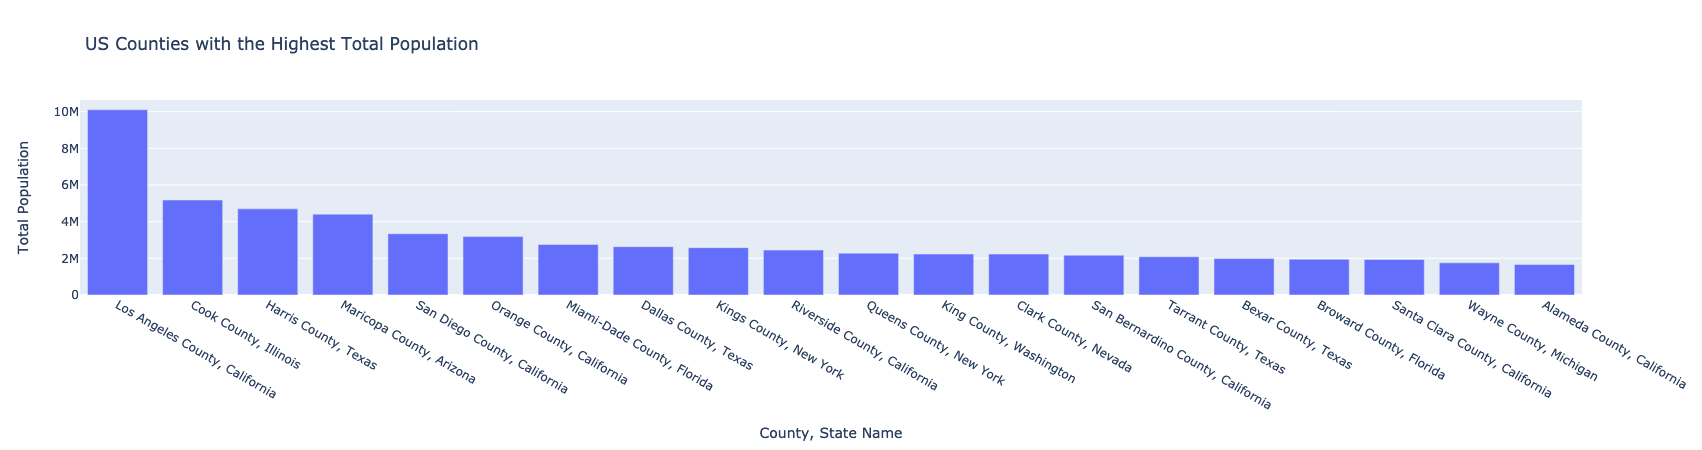

In [115]:
# make a graph to show percent of largest 18 under population 
bar_total_pop = px.bar(df_total_top20,
                   x = "Geographic Area N",
                   y = "Total",
                   title = "US Counties with the Highest Total Population",
                   labels = {"Geographic Area N": "County, State Name", "Total": "Total Population"})

bar_total_pop

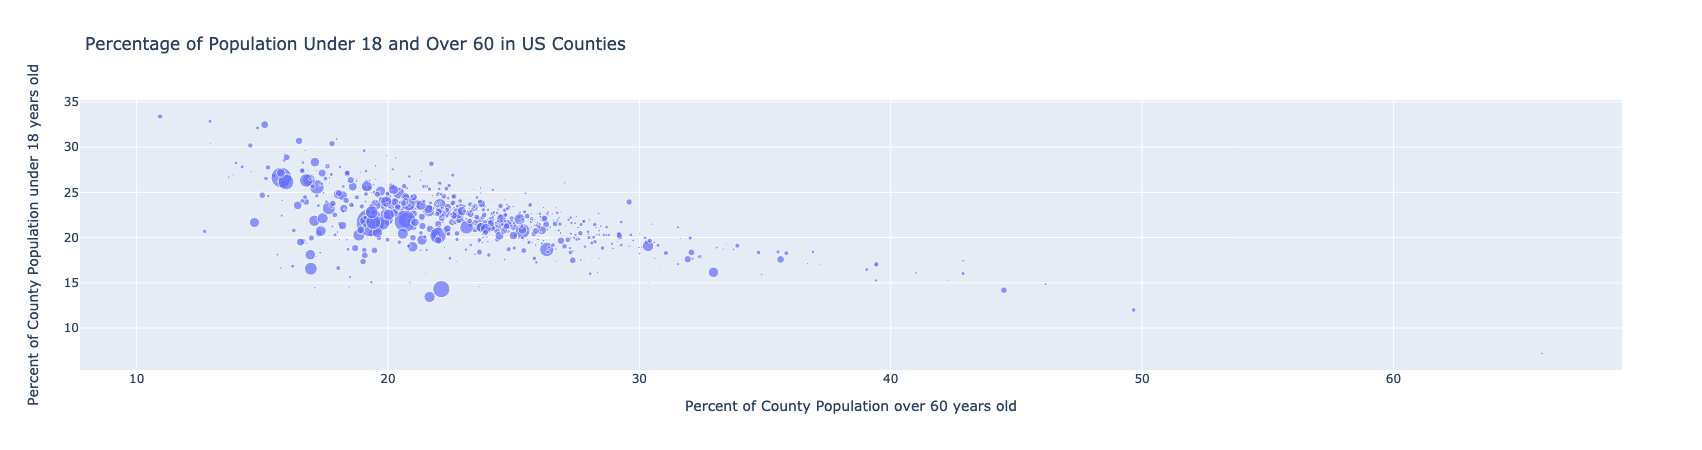

In [116]:
# make a graph to show percent of largest 18 under population 
bubble_u18_o60 = px.scatter(df_county_health,
                            x = "percent_over60",
                            y = "percent_under18",
                            size = "hospital_bed_count",
                            hover_data = ['Geographic Area N',"Total"],
                            title = "Percentage of Population Under 18 and Over 60 in US Counties",
                            labels = {"Geographic Area N": "County, State Name",
                                      "Total": "Total Population",
                                      "percent_over60": "Percent of County Population over 60 years old",
                                      "percent_under18": "Percent of County Population under 18 years old"})

bubble_u18_o60

In [117]:
# make a column to standardize hospital bed count
# number of hospital beds per 1,000 people
df_county_health["hospitalbeds_per1000"] = (df_county_health["hospital_bed_count"]/df_county_health["Total"])*1000

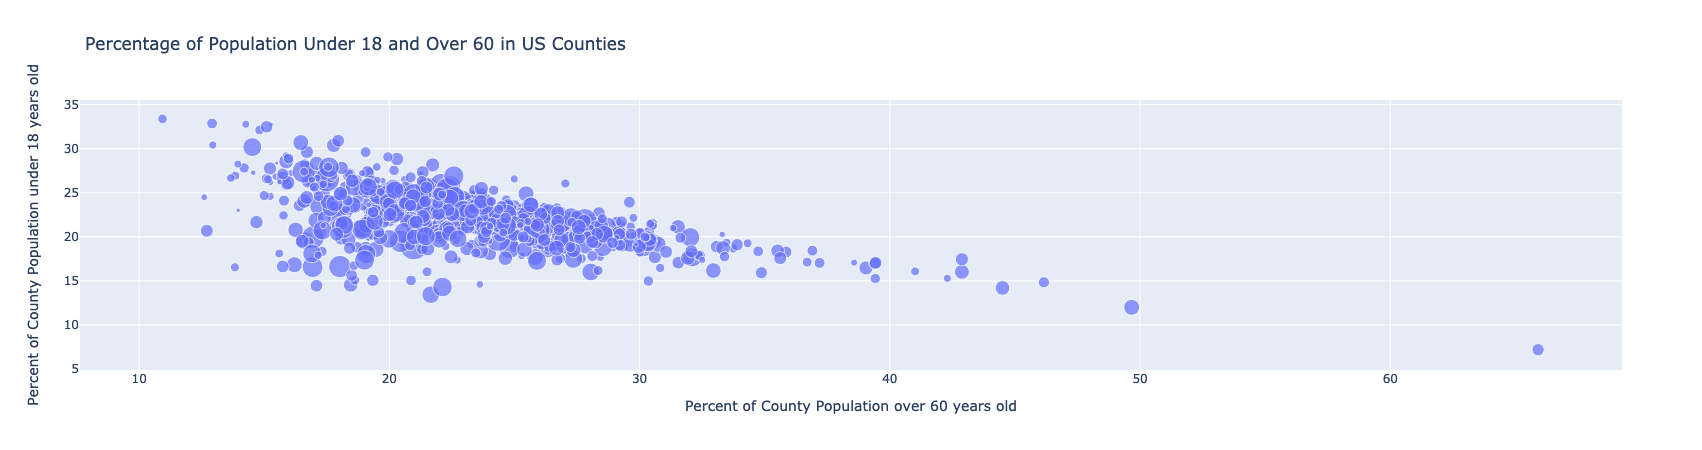

In [118]:
# make a graph to show percent of largest 18 under population 
# with bubble size corresponding to #hospital beds per 1000 people
bubble_u18_o60_beds = px.scatter(df_county_health,
                            x = "percent_over60",
                            y = "percent_under18",
                            size = "hospitalbeds_per1000",
                            hover_data = ['Geographic Area N',"Total"],
                            title = "Percentage of Population Under 18 and Over 60 in US Counties",
                            labels = {"Geographic Area N": "County, State Name",
                                      "Total": "Total Population",
                                      "percent_over60": "Percent of County Population over 60 years old",
                                      "percent_under18": "Percent of County Population under 18 years old",
                                     "hospitalbeds_per1000": "Number of Hospital Beds per 1000 People"})

bubble_u18_o60_beds

### 6. Merge the COVID-19 growth data onto the population dataframe

In [119]:
# create a new dataframe that only includes the most recent coronavirus data
df_covid_apr10 = df_covid[df_covid["date"]== "2020-04-10"]

# first, remove null values from fips
df_covid_apr10 = df_covid_apr10[df_covid_apr10["fips"].notnull()]

# convert fips number to int and then string
df_covid_apr10["fips"] = df_covid_apr10["fips"].astype(int)
df_covid_apr10["fips"] = df_covid_apr10["fips"].astype(str)

# adding preceding zeros so that the FIPS code includes 5 digits
df_covid_apr10["fips"] = df_covid_apr10["fips"].str.zfill(5)

In [120]:
# merge covid data to df_county_health data
df_county_health = pd.merge(df_county_health,
                           df_covid_apr10[["fips", "cases", "deaths"]],
                           how = "left",
                           left_on = "full_county_fips",
                           right_on = "fips")

In [121]:
# make two more columns that show number of cases/deaths per 1000 people
df_county_health["cases_per1000"] = (df_county_health["cases"]/df_county_health["Total"])*1000
df_county_health["deaths_per1000"] = (df_county_health["deaths"]/df_county_health["Total"])*1000

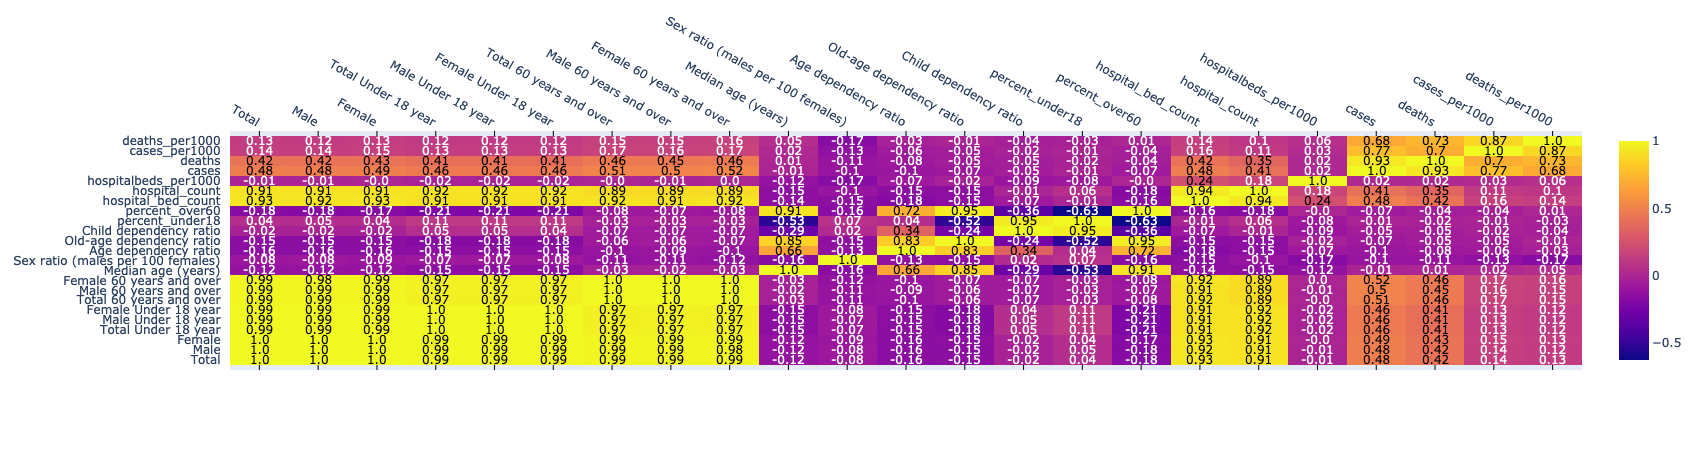

In [122]:
# correlation table
covid_corr = df_county_health.corr()

# make an annotated heatmap
county_covid19_heatmap = ff.create_annotated_heatmap(z = covid_corr.values, 
                                       x=list(covid_corr.columns), 
                                       y=list(covid_corr.index), 
                                       annotation_text=covid_corr.round(2).values, 
                                       showscale = True 
                                       )

county_covid19_heatmap

# Creating More Plotly Visualizations 

In [123]:
df_county_health.head()

,d,Geographic Area N,Total,Male,Female,Total Under 18 year,Male Under 18 year,Female Under 18 year,Total 60 years and over,Male 60 years and over,...,percent_over60,COUNTYFIPS,hospital_bed_count,hospital_count,hospitalbeds_per1000,fips,cases,deaths,cases_per1000,deaths_per1000
0,0500000US01117,"Shelby County, Alabama",215707,105022,110685,48670,25382,23288,47098,21899,...,21.834247,01117,349.0,3.0,1.617935,01117,185.0,5.0,0.857645,0.023180
1,0500000US01121,"Talladega County, Alabama",79828,38489,41339,16810,8292,8518,20479,8991,...,25.653906,01121,285.0,2.0,3.570176,01121,32.0,0.0,0.400862,0.000000
2,0500000US01125,"Tuscaloosa County, Alabama",208911,99576,109335,43992,21652,22340,39432,18110,...,18.875023,01125,933.0,4.0,4.466017,01125,91.0,0.0,0.435592,0.000000
3,0500000US04021,"Pinal County, Arizona",447138,233292,213846,101143,52140,49003,118634,56331,...,26.531854,04021,249.0,3.0,0.556875,04021,138.0,3.0,0.308630,0.006709
4,0500000US06045,"Mendocino County, California",87606,43017,44589,18535,9033,9502,25968,12178,...,29.641805,06045,141.0,3.0,1.609479,06045,4.0,0.0,0.045659,0.000000


In [124]:
# sort county data by 18 under population 
df_county_health = df_county_health.sort_values(by = "percent_over60", ascending = False)

# top 20 
df_county_percent_over60_top20 = df_county_health.head(20)
top20_county_percent_over60 = df_county_percent_over60_top20["Geographic Area N"].tolist()

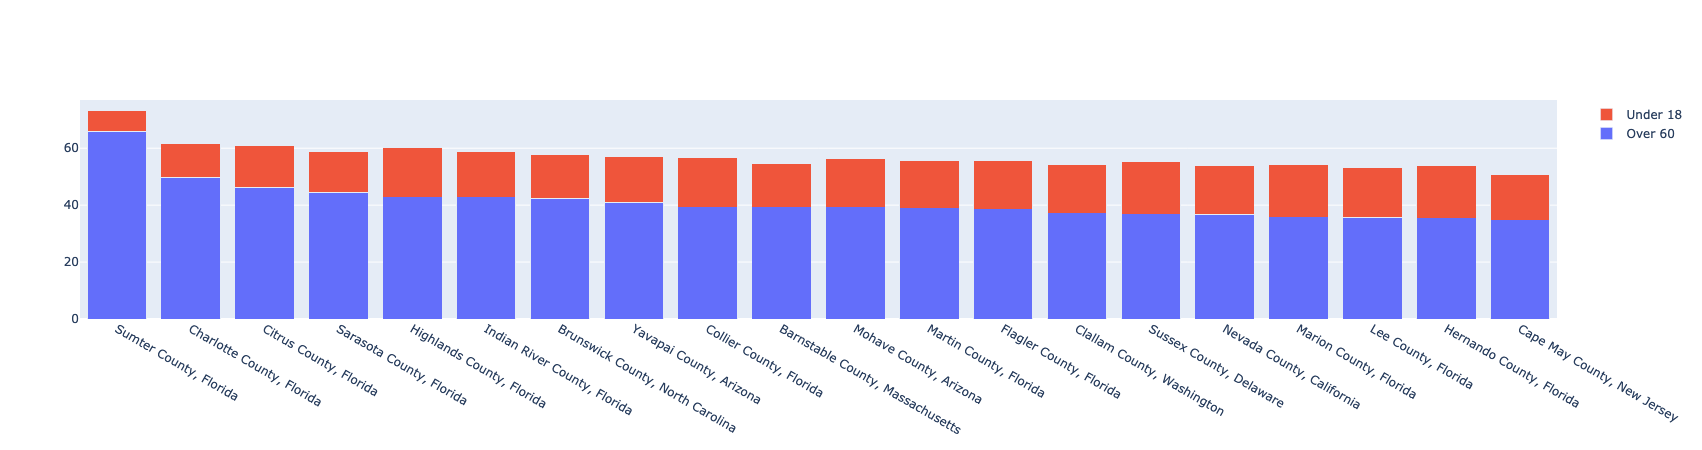

In [125]:
fig = go.Figure(data=[
    go.Bar(name='Over 60', x=top20_county_percent_over60, y=df_county_health["percent_over60"]),
    go.Bar(name='Under 18', x=top20_county_percent_over60, y=df_county_health["percent_under18"])
])

fig.update_layout(barmode='stack')
fig.show()

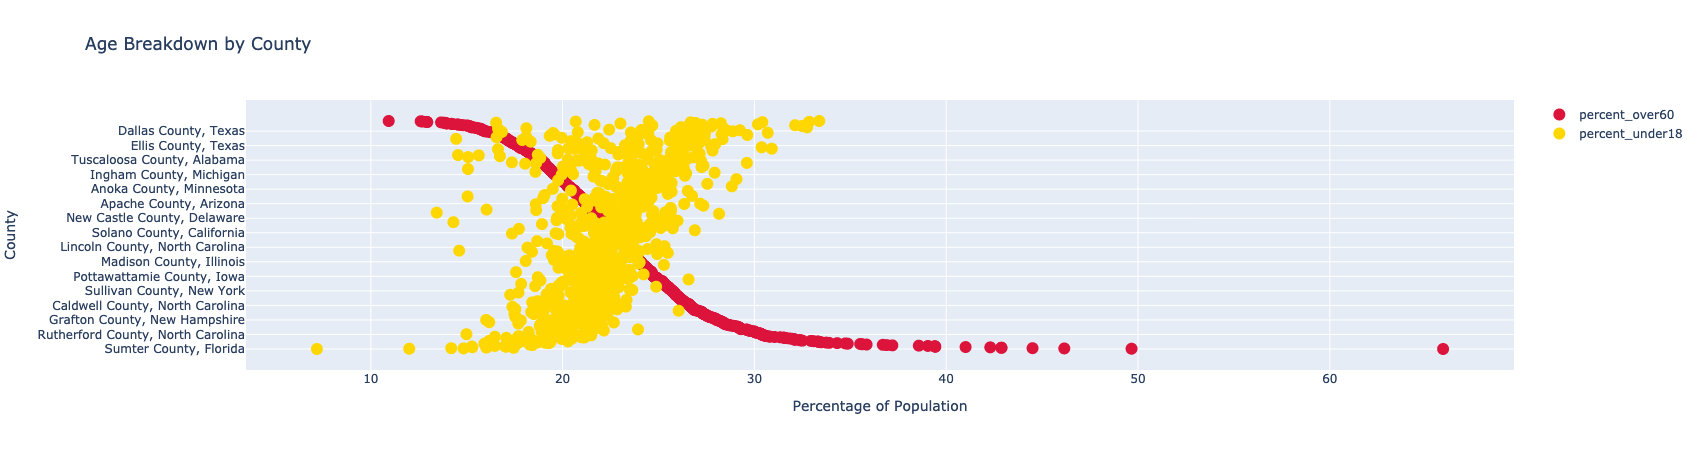

In [126]:
all_counties = df_county_health["Geographic Area N"].tolist()

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_county_health["percent_over60"],
    y=all_counties,
    marker=dict(color="crimson", size=12),
    mode="markers",
    name="percent_over60",
))

fig.add_trace(go.Scatter(
    x=df_county_health["percent_under18"],
    y=all_counties,
    marker=dict(color="gold", size=12),
    mode="markers",
    name="percent_under18",
))

fig.update_layout(title="Age Breakdown by County",
                  xaxis_title="Percentage of Population",
                  yaxis_title="County")

fig.show()


## Shown Visualization

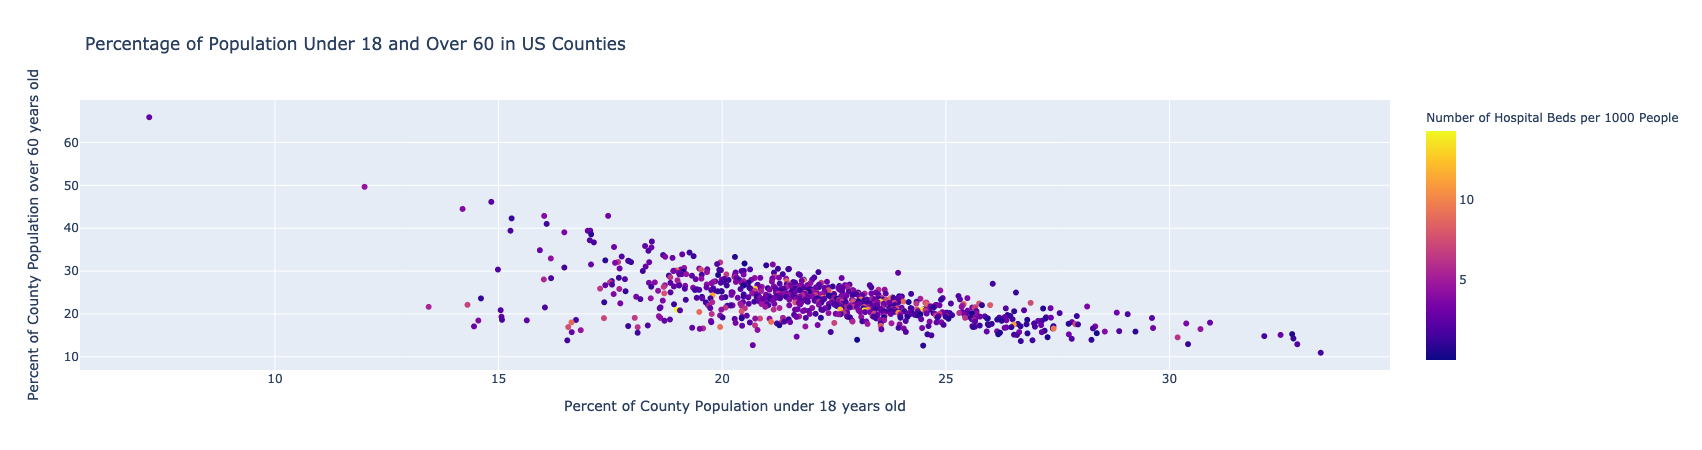

In [128]:
bubble_u18_o60_beds = px.scatter(df_county_health,
                            x = "percent_under18",
                            y = "percent_over60",
                            color = "hospitalbeds_per1000",
                            hover_data = ['Geographic Area N',"Total"],
                            title = "Percentage of Population Under 18 and Over 60 in US Counties",
                            labels = {"Geographic Area N": "County, State Name",
                                      "Total": "Total Population",
                                      "percent_over60": "Percent of County Population over 60 years old",
                                      "percent_under18": "Percent of County Population under 18 years old",
                                     "hospitalbeds_per1000": "Number of Hospital Beds per 1000 People"})

bubble_u18_o60_beds